In [14]:
'''
************************************************
** COL774 Machine Learning
** Assignment 2
** Part A: Naive Bayes | Twitter Sentiment Classification
** @Author: Aman Bhardwaj
** @Entry No. 2019SIY7580
** @Date: 14 Feb 2020
************************************************
'''

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import math

import nltk
from bs4 import BeautifulSoup
import string
import re
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.util import ngrams

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc


In [15]:
def readCSV(fName):
    '''Read Data'''
    d = pd.read_csv(fName, usecols = [0,5], encoding = "ISO-8859-1",
                   names=['Class', 'Comments'])
    return d

#read Training Data
DTrain = readCSV("training.1600000.processed.noemoticon.csv")
#Read Testing Data
DTest = readCSV("testdata.manual.2009.06.14.csv")

Training Data Classes 
 Class
0    800000
4    800000
dtype: int64


<Figure size 432x288 with 0 Axes>

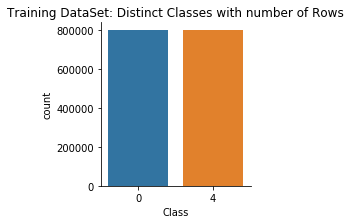


Test Data Classes
Class
0    177
4    182
dtype: int64


<Figure size 432x288 with 0 Axes>

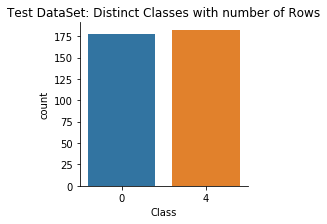

In [16]:
distinctTrainClass = DTrain.pivot_table(index=['Class'], aggfunc='size')
print("Training Data Classes \n", distinctTrainClass)
fig = plt.figure(1)
sns0 = sns.catplot(x="Class", data=DTrain, kind="count", height=3, aspect=1)
plt.title('Training DataSet: Distinct Classes with number of Rows')
plt.show()
#sns0.savefig("plots/DTrain_Distinct_Classes.png", dpi= 300, pad_inches=0.1, format='png')

print("\nTest Data Classes")
print (DTest.pivot_table(index=['Class'], aggfunc='size'))
fig1 = plt.figure(2)
sns1 = sns.catplot(x="Class", data=DTest, kind="count", height=3, aspect=1)
plt.title('Test DataSet: Distinct Classes with number of Rows')
plt.show()
#sns1.savefig("plots/DTest_Distinct_Classes.png", dpi= 300, pad_inches=0.1, format='png')

In [17]:
def deleteMentionedUsers(txt):
    '''This removes mentions of other users from the comments'''
    
    processedText = re.sub('@\w+', '', txt)
    return processedText

def deleteUrls(txt):
    '''This removes URLs from the comments as URL carry no or very less information'''
    
    processedText = re.sub(r'http.?://[^\s]+[\s]?', '', txt)
    return processedText

def deleteDigits(txt):
    '''This removes digits from the comments as they carry no or very less information'''
    
    processedText = re.sub(r'\d+', '', txt)
    return processedText

punctuations = string.punctuation
def deletePunctuations(txt):
    '''This removes punctuations from the given text which are there in string.punctuations lib'''
    
    #punctuations = string.punctuation
    processedText = "".join([t for t in txt if t not in punctuations ])
    return processedText

stopwordsList = stopwords.words('english')
# include words which includes sentiments
whitelist = ["n't", "not", "no"] 
def remove_stopwords(txt):
    '''This removes stop words from text which are very frequent but they do dot carry much sentiments'''
    words = txt.split()
    
    clean_words = [word for word in words if (word not in stopwordsList or word in whitelist) and len(word) > 1] 
    return " ".join(clean_words)

stemmer = PorterStemmer()

def textStemmer(txt):
    stemText = " ".join([stemmer.stem(word) for word in txt.split()])
    return stemText

def processDataBasic(data):
    '''
    This creates list of words for each comment row so that i can be used to build vocabulary
    
    Params: 
    data: data to be preprocessed
    
    Return:
    data: processed data
    dTrain0, dTrain4: processed data split by class  
    
    '''
    print("@@@@@@@@---Pre-processing of Tweets---@@@@@@@@")
    sTime = time.time()

    data['Comments'] = data['Comments'].apply(lambda x: x.lower().split())
    dTrain0, dTrain4 = split(data)
    

    eTime = time.time()
    print("PreProcessing Time: ", round(eTime - sTime, 3))
    return data, dTrain0, dTrain4

def trainNB(data):
    '''
    This function trains the Naive Bayes Model for Text Classification
    
    Params: 
    data: Training Data
    
    Return:
    V: Vocabulary built from data
    Freq0: number of occurances of each distinct word in Class 0
    Freq4: number of occurances of each distinct word in Class 4 
    ni0: Number of words in class 0
    ni4: Number of words in class 4  
    Phi0,Phi4, Theta0, Theta4: Naive Bayes Params for each class 
    '''
    comment = "Naive Bayes Training in progress...!"
    V = {}
    Freq0 = {}
    Freq4 = {}
    ni0 = 0
    ni4 = 0   
    count0 = 0
    count4 = 0
    eTime = time.time()
    print("\n@@@@@@@@---{}---@@@@@@@@".format(comment))
    sTime = time.time()
    for eg in data:
        if eg[0] == 0:
            count0 += 1
            for w in str(eg[1]).lower().split():
                if w not in V:
                    V[w] = 1
                    Freq0[w] = 1
                    ni0 += 1
                else:
                    V[w] += 1
                    if w not in Freq0:
                        Freq0[w] = 1
                        ni0 += 1
                    else:                        
                        Freq0[w] += 1
                        ni0 += 1
        else:
            count4 += 1
            for w in str(eg[1]).lower().split():
                if w not in V:
                    V[w] = 1
                    Freq4[w] = 1
                    ni4 += 1
                else:
                    V[w] += 1
                    if w not in Freq4:
                        Freq4[w] = 1
                        ni4 += 1
                    else:                        
                        Freq4[w] += 1
                        ni4 += 1 

    print("\nCalculating Parameters...!")                    
    Phi0 = count0/(count0 + count4)
    Phi4 = count4/(count0 + count4)
    
    theta0 = {}
    theta4 = {}
    theta0, theta4 = calcTheta(V, Freq0, Freq4, ni0, ni4)
    
    eTime = time.time()
    print("Training Time: ", round(eTime - sTime, 3), "Sec")
    return V, Freq0, Freq4, ni0, ni4, Phi0, Phi4, theta0, theta4
 

def calcTheta(vocab, dic0, dic4, ni0, ni4):
    '''
    This function calculates Theta Parameters for NB values
    
    Params: 
    vocab: vocabulary from tweets
    dict0: number of occurances of each distinct word in Class 0
    dict4: number of occurances of each distinct word in Class 4 
    ni0: Number of words in class 0
    ni4: Number of words in class 4  
    
    Return:
    Theta0, Theta4: Theta Parameters for each class of NB
    '''
    
    th0 = {}
    th4 = {}
    vocabLen = len(vocab)
    for word in vocab:
        th0[word] = ((0 if word not in dic0 else dic0[word]) + 1) / (ni0 + vocabLen)
        th4[word] = ((0 if word not in dic4 else dic4[word]) + 1) / (ni4 + vocabLen)
    
    return th0, th4

def predict(tweet):
    '''For a given tweet this predicts whether it belongs to class 0 or 4'''
    likelihood0 = 0.0
    likelihood4 = 0.0
    for word in str(tweet).lower().split():
        if word not in Vocab:
            likelihood0 += np.log(1/(Ni0 + len(Vocab)))
            likelihood4 += np.log(1/(Ni4 + len(Vocab)))
        else:
            likelihood0 += np.log(Theta0[word])
            likelihood4 += np.log(Theta4[word])
    likelihood0 += np.log(Phi0)
    likelihood4 += np.log(Phi4)
    return 0 if likelihood0 > likelihood4 else 4
        
def calcAccuracy(pred, act):
    '''This calculates whether predicted label is same as actual label or not'''
    diff = pred - act
    result = []
    for i in diff:
        if i == 0:
            result.append(True)
        else:
            result.append(False)      
    return np.array(result).reshape(act.shape)
        
    
def testNB(data):
    '''
    This function trains the Naive Bayes Model for Text Classification
    
    Params: 
    data: Training Data
    
    Return:
    results: result vector
    accuracy: accuracy of data
    '''
    print("\nTesting in progress...!")
    sTime = time.time()
    
    predicted = np.array([predict(eg) for eg in data[:,1]])
    actual = np.array(data[:,0])
    results = calcAccuracy(predicted ,actual)
    
    result = pd.DataFrame(results).pivot_table(index=[0], aggfunc='size')
    nTrue = result[True]
    
    accuracy = round(nTrue/len(results), 5)*100    
    
    eTime = time.time()    
    print("Testing Time: ", round(eTime - sTime, 3), "Sec")
    return accuracy, results

def randMajorityAccuracy(data):
    '''This calculates the accurace for scenarios mentioned in question b'''
    print("\n@@@@@@@@---Calculating Random/Majority Prediction Accuracy...!---@@@@@@@@")
    cls = [0, 4]
    avgRandAccu = 0
    for i in range(100):
        randPredict = np.random.choice(cls , len(data))
        actual = np.array(data[:,0])

        results = calcAccuracy(randPredict ,actual)
        result = pd.DataFrame(results).pivot_table(index=[0], aggfunc='size')
        nTrue = result[True]
        randAccuracy = round(nTrue/len(results), 5)*100
        avgRandAccu += randAccuracy
        
    avgRandAccu = avgRandAccu/100
    testDataAnalysis = pd.DataFrame(data).pivot_table(index=[0], aggfunc='size')
    n0 = testDataAnalysis[0]
    n4 = testDataAnalysis[4]
    
    majorityAcc = (max(n0, n4)/len(data))*100
    
    print("\nRandom Prediction Accuracy = {}%".format(avgRandAccu))
    print("Majority Accuracy = {}%".format(majorityAcc))
    return

def calcConfusionMatrix(dataLabels, results):
    confusionMat = np.zeros((2,2)).astype(int)
    
    for i in range(len(dataLabels)):
        if dataLabels[i] == 0:
            if results[i] == True:
                confusionMat[0][0] += 1
            else:                
                confusionMat[1][0] += 1                
        else:
            if results[i] == True:
                confusionMat[1][1] += 1
            else:                
                confusionMat[0][1] += 1
    print("\nConfusion Matrix:\n", confusionMat)
    confusionMat = np.array([[confusionMat[0][0],confusionMat[0][1],],[confusionMat[1][0], confusionMat[1][1]]])
    cm_df = pd.DataFrame(confusionMat.astype(int), index = [i for i in "04"],
                      columns = [i for i in "04"])
    fig = plt.figure(1)
    akws = {'ha':'center', 'va':'center'}
    sns.heatmap(cm_df, annot=True, fmt="d", center=1, cmap="YlGnBu", annot_kws = akws)
    plt.yticks(rotation=0, fontsize="12", va="center")
    plt.xticks(rotation=0, fontsize="12", va="center")
    plt.title("Confusion Matrix")
    plt.show()
    fig.savefig("plots/Confusion_Matrix.png", dpi= 300, pad_inches=0.1, format='png')
    return confusionMat

def modelWithPreProcessing(data):
    sTime = time.time()
    print('----Cleaning in Progress----')
    data['Comments'] = data['Comments'].apply(lambda x: deleteUrls(x.lower()))
    data['Comments'] = data['Comments'].apply(lambda x: deleteMentionedUsers(x))
    data['Comments'] = data['Comments'].apply(lambda x: deleteDigits(x))
    data['Comments'] = data['Comments'].apply(lambda x: remove_stopwords(x))
    data['Comments'] = data['Comments'].apply(lambda x: deletePunctuations(x))
    data['Comments'] = data['Comments'].apply(lambda x: textStemmer(x))
    
    eTime = time.time()
    print("Cleaning RunTime", eTime - sTime)
    return data


positiveWords = []
negativeWords = []
f = open("positive-words.txt", "r")
for x in f:
    positiveWords.append(x.rstrip("\n")) 
f.close()
f = open("negative-words.txt", "r")
for x in f:
    negativeWords.append(x.rstrip("\n"))
f.close()

negativeWeight = 0.009
positiveWeight = 0.009
def predictFEModel1(tweet):
    '''For a given tweet this predicts whether it belongs to class 0 or 4'''
    likelihood0 = 0.0
    likelihood4 = 0.0
    
    for word in str(tweet).lower().split():
        if word not in Vocab:
            if word not in negativeWords:
                likelihood0 += np.log(1/(Ni0 + len(Vocab)))
            else:
                likelihood0 += np.log(1 + negativeWeight)                        
            
            if word not in positiveWords:
                likelihood4 += np.log(1/(Ni4 + len(Vocab)))
            else:
                likelihood4 += np.log(1/(Ni4 + len(Vocab))+ positiveWeight)
        else:
            if word not in negativeWords:
                likelihood0 += np.log(Theta0[word])
            else:
                likelihood0 += np.log(Theta0[word] + negativeWeight)
                                      
            if word not in positiveWords:
                likelihood4 += np.log(Theta4[word])
            else:
                likelihood4 += np.log(Theta4[word] + positiveWeight)
          
    likelihood0 += np.log(Phi0)
    likelihood4 += np.log(Phi4)
    return 0 if likelihood0 > likelihood4 else 4
        
    
def testFEModel1(data):
    '''
    This function trains the Naive Bayes Model for Text Classification
    
    Params: 
    data: Training Data
    
    Return:
    results: result vector
    accuracy: accuracy of data
    '''
    print("\n Testing in progress...!")
    sTime = time.time()
    
    
    predicted = np.array([predictFEModel1(eg) for eg in data[:,1]])
    actual = np.array(data[:,0])
    results = calcAccuracy(predicted ,actual)
    
    result = pd.DataFrame(results).pivot_table(index=[0], aggfunc='size')
    nTrue = result[True]
    
    accuracy = round(nTrue/len(results), 5)*100    
    
    eTime = time.time()    
    print("Testing Time: ", round(eTime - sTime, 3), "Sec")
    return accuracy, results

def trainBigramNB(data):
    '''
    This function trains the Naive Bayes Model for Text Classification
    
    Params: 
    data: Training Data
    
    Return:
    V: Vocabulary built from data
    Freq0: number of occurances of each distinct word in Class 0
    Freq4: number of occurances of each distinct word in Class 4 
    ni0: Number of words in class 0
    ni4: Number of words in class 4  
    Phi0,Phi4, Theta0, Theta4: Naive Bayes Params for each class 
    '''
    comment = "NGram - Naive Bayes Training in progress...!"
    V = {}
    Freq0 = {}
    Freq4 = {}
    ni0 = 0
    ni4 = 0   
    count0 = 0
    count4 = 0
    weight = 1
    eTime = time.time()
    print("\n@@@@@@@@---{}---@@@@@@@@".format(comment))
    sTime = time.time()
    for eg in data:
        if eg[0] == 0:
            count0 += 1
            for w in eg[1]:
                if w not in V:
                    V[w] = weight
                    Freq0[w] = weight
                    ni0 += 1
                else:
                    V[w] += weight
                    if w not in Freq0:
                        Freq0[w] = weight
                        ni0 += 1
                    else:                        
                        Freq0[w] += weight
                        ni0 += 1
        else:
            count4 += 1
            for w in eg[1]:
                if w not in V:
                    V[w] = weight
                    Freq4[w] = weight
                    ni4 += 1
                else:
                    V[w] += weight
                    if w not in Freq4:
                        Freq4[w] = weight
                        ni4 += 1
                    else:                        
                        Freq4[w] += weight
                        ni4 += 1 

    print("\nCalculating Parameters...!")                    
    Phi0 = count0/(count0 + count4)
    Phi4 = count4/(count0 + count4)
    
    theta0 = {}
    theta4 = {}
    V.update(Vocab)
    Freq0.update(WordsFreq0)
    Freq4.update(WordsFreq4)
    ni0 += Ni0
    ni4 +=Ni4
    theta0, theta4 = calcTheta(V, Freq0, Freq4, ni0, ni4)
    
    eTime = time.time()
    print("Training Time: ", round(eTime - sTime, 3), "Sec")
    return V, Freq0, Freq4, ni0, ni4, Phi0, Phi4, theta0, theta4

def generateNgrams(txt, n):
    # Break sentence in the token, remove empty tokens
    tokens = [token for token in txt.split(" ") if token != ""]
    
    ngrams = zip(*[tokens[i:] for i in range(n)])
    return [" ".join(ngram) for ngram in ngrams]

def predictNGramModel(tweet):
    '''For a given tweet this predicts whether it belongs to class 0 or 4'''
    likelihood0 = 0.0
    likelihood4 = 0.0
    
    for word in str(tweet).split():
        if word not in Vocab:
            likelihood0 += np.log(1/(Ni0 + len(Vocab)))
            likelihood4 += np.log(1/(Ni4 + len(Vocab)))
        else:
            likelihood0 += np.log(Theta0[word])
            likelihood4 += np.log(Theta4[word])
           
    tweetTokens = generateNgrams(tweet, 2)        
    for word in tweetTokens:
        if word not in Vocab:
            likelihood0 += np.log(1/(Ni0 + len(Vocab)))
            likelihood4 += np.log(1/(Ni4 + len(Vocab)))
        else:
            likelihood0 += np.log(Theta0[word])
            likelihood4 += np.log(Theta4[word])
            
    likelihood0 += np.log(Phi0)
    likelihood4 += np.log(Phi4)
    return 0 if likelihood0 > likelihood4 else 4

       
def testNGramModel(data):
    '''
    This function trains the Naive Bayes Model for Text Classification
    
    Params: 
    data: Training Data
    
    Return:
    results: result vector
    accuracy: accuracy of data
    '''
    print("\nTesting in progress...!")
    sTime = time.time()
    predicted = np.array([predictNGramModel(eg) for eg in data[:,1]])
    actual = np.array(data[:,0])
    results = calcAccuracy(predicted ,actual)
    
    result = pd.DataFrame(results).pivot_table(index=[0], aggfunc='size')
    nTrue = result[True]
    
    accuracy = round(nTrue/len(results), 5)*100    
    
    eTime = time.time()    
    print("Testing Time: ", round(eTime - sTime, 3), "Sec")
    return accuracy, results



def predictProb(tweet):
    '''For a given tweet this predicts whether it belongs to class 0 or 4'''
    likelihood0 = 0.0
    likelihood4 = 0.0
    for word in str(tweet).lower().split():
        if word not in Vocab:
            likelihood0 += np.log(1/(Ni0 + len(Vocab)))
            likelihood4 += np.log(1/(Ni4 + len(Vocab)))
        else:
            likelihood0 += np.log(Theta0[word])
            likelihood4 += np.log(Theta4[word])
    likelihood0 += np.log(Phi0)
    likelihood4 += np.log(Phi4)
    
    return likelihood0, likelihood4


def plotROC_Curve(data):
    '''Plot ROC Curve'''
    sTime = time.time()
    arr = [data[:,0]]
    arr = arr[0].reshape(len(data), 1)
    binArr = []
    for i in range(len(arr)):
        if arr[i] == 4:
            binArr.append(1)
        else:
            binArr.append(0)
    binArr = np.array(binArr).reshape(len(data), 1)
    
    predicted = np.array([predictProb(eg) for eg in data[:,1]]).reshape(len(data),2)
    #print(predicted)
    prob4 = []
    for i in range(len(predicted)):
        prob4.append(abs(predicted[i][1])/abs(predicted[i][0] + predicted[i][1]))
        
    prob4 = np.array(prob4)
    lin = np.linspace(0, 1, 20)
    fig = plt.figure(1)    
    fpr, tpr, th = roc_curve(binArr, prob4, pos_label=None)
    plt.plot(tpr, fpr, c="tab:orange", label="ROC Curve")
    plt.plot(lin, lin, c="tab:green", linestyle="dashed", label="Random")
    plt.legend()
    plt.ylabel("True Positive Rate")
    plt.xlabel("False Positive Rate")
    plt.title("ROC Curve")
    plt.show()
    fig.savefig("plots/ROC_CURVE.png", dpi= 300, pad_inches=0.1, format='png')
    
    print("AUC SCORE", auc(tpr, fpr))
    
    eTime = time.time()    
    print("Testing Time: ", round(eTime - sTime, 3), "Sec")


################
------Q1_a------
################

@@@@@@@@---Naive Bayes Training in progress...!---@@@@@@@@

Calculating Parameters...!
Training Time:  15.805 Sec

@@@@@@@@---Calculate Train Accuracy...!---@@@@@@@@

Testing in progress...!
Testing Time:  59.412 Sec

@@@@@@@@---Calculate Test Accuracy...!---@@@@@@@@

Testing in progress...!
Testing Time:  0.016 Sec

Train Accuracy = 85.828%
Test Accuracy = 80.501%

################
------Q1_b------
################

@@@@@@@@---Calculating Random/Majority Prediction Accuracy...!---@@@@@@@@

Random Prediction Accuracy = 50.214450000000014%
Majority Accuracy = 50.69637883008357%

################
------Q1_c------
################

Confusion Matrix:
 [[145  38]
 [ 32 144]]


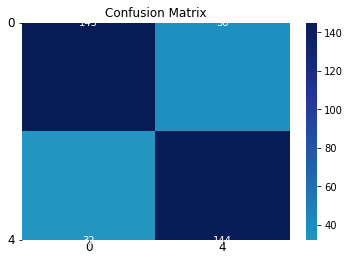


################
------Q1_d------
################

@@@@@@@@---Naive Bayes Training in progress...!---@@@@@@@@

Calculating Parameters...!
Training Time:  7.79 Sec

@@@@@@@@---Calculate Train Accuracy...!---@@@@@@@@

Testing in progress...!
Testing Time:  33.569 Sec

@@@@@@@@---Calculate Test Accuracy...!---@@@@@@@@
----Cleaning in Progress----
Cleaning RunTime 0.1093451976776123

Testing in progress...!
Testing Time:  0.016 Sec

Train Accuracy = 80.238%
Test Accuracy = 81.616%

################
------Q1_e------
################
+++++++++ Feature Extraction Model 1 ++++++++++

@@@@@@@@---Naive Bayes Training in progress...!---@@@@@@@@

Calculating Parameters...!
Training Time:  14.836 Sec

@@@@@@@@---Model 1: Calculate Test Accuracy---@@@@@@@@

 Testing in progress...!
Testing Time:  0.375 Sec
Test Accuracy = 83.00800000000001%

@@@@@@@@---Model 2: Calculate Test Accuracy---@@@@@@@@

@@@@@@@@---Naive Bayes Training in progress...!---@@@@@@@@

Calculating Parameters...!
Training Time: 

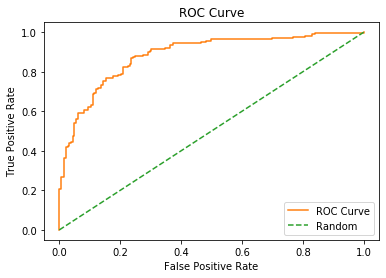

AUC SCORE 0.8839634941329856
Testing Time:  0.281 Sec

@@@@@@@@---Naive Bayes Training in progress...!---@@@@@@@@

Calculating Parameters...!
Training Time:  8.311 Sec

Testing in progress...!
Testing Time:  0.0 Sec
81.616


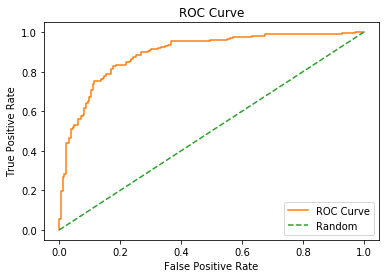

AUC SCORE 0.893089960886571
Testing Time:  0.792 Sec


In [18]:
Vocab = {} #vocabulary of whole dataset
WordsFreq0 = {} #number of occourance of words in class = 0
WordsFreq4 = {}  #number of occourance of words in class = 4
Ni0 = 0
Ni4 = 0
Phi0 = 0.0
Phi4 = 0.0
Theta0 = {}
Theta4 = {}
if __name__ == "__main__":
    
    print("\n################\n------Q1_a------\n################")
    Vocab, WordsFreq0, WordsFreq4, Ni0, Ni4, Phi0, Phi4, Theta0, Theta4 = trainNB(DTrain.to_numpy())
    print("\n@@@@@@@@---Calculate Train Accuracy...!---@@@@@@@@")
    AccuTrain, ResultsTrain = testNB(DTrain.to_numpy())
    print("\n@@@@@@@@---Calculate Test Accuracy...!---@@@@@@@@")
    AccuTest, ResultsTest = testNB(DTest.to_numpy())
    
    print("\nTrain Accuracy = {}%".format(AccuTrain))
    print("Test Accuracy = {}%".format(AccuTest))
    
    print("\n################\n------Q1_b------\n################")
    randMajorityAccuracy(DTest.to_numpy())
    
    print("\n################\n------Q1_c------\n################")
    cmf = calcConfusionMatrix(DTest.to_numpy()[:,0], ResultsTest)
    
    
    print("\n################\n------Q1_d------\n################")
    #print(DTrain)
    #DTrain_P = modelWithPreProcessing(DTrain.filter(['Class','Comments'], axis=1))
    #DTrain_P.to_csv(r'Processed_Training_Data_withoutPunct.csv')
    DTrain_P = pd.read_csv("Processed_Training_Data_withoutPunct.csv", usecols = [1,2], encoding = "ISO-8859-1")
    
    DTrain_P['Comments'].replace('', np.nan, inplace=True)
    DTrain_P.dropna(subset=['Comments'], inplace=True)
    Vocab, WordsFreq0, WordsFreq4, Ni0, Ni4, Phi0, Phi4, Theta0, Theta4 = trainNB(DTrain_P.to_numpy())
    
    print("\n@@@@@@@@---Calculate Train Accuracy...!---@@@@@@@@")
    AccuTrain, ResultsTrain = testNB(DTrain_P.to_numpy())
    print("\n@@@@@@@@---Calculate Test Accuracy...!---@@@@@@@@")
    DTest_P = modelWithPreProcessing(DTest.filter(['Class','Comments'], axis=1))
    DTest_P['Comments'].replace('', np.nan, inplace=True)
    DTest_P.dropna(subset=['Comments'], inplace=True)
    AccuTest, ResultsTest = testNB(DTest_P.to_numpy())

    print("\nTrain Accuracy = {}%".format(AccuTrain))
    print("Test Accuracy = {}%".format(AccuTest))
    
    print("\n################\n------Q1_e------\n################")
    
    print("+++++++++ Feature Extraction Model 1 ++++++++++")
    Vocab, WordsFreq0, WordsFreq4, Ni0, Ni4, Phi0, Phi4, Theta0, Theta4 = trainNB(DTrain.to_numpy())
    #print("\n@@@@@@@@---Model 1: Calculate Train Accuracy---@@@@@@@@")
    #AccuTrain_FE, ResultsTrain_FE = testFEModel1(DTrain.to_numpy())
    
    
    print("\n@@@@@@@@---Model 1: Calculate Test Accuracy---@@@@@@@@")
    AccuTest_FE, ResultsTest_FE = testFEModel1(DTest.to_numpy())
    #print("\nTrain Accuracy = {}%".format(AccuTrain_FE))
    print("Test Accuracy = {}%".format(AccuTest_FE))
    
    print("\n@@@@@@@@---Model 2: Calculate Test Accuracy---@@@@@@@@")
    DTrain_BG = DTrain_P.filter(['Class','Comments'], axis=1)
    Vocab, WordsFreq0, WordsFreq4, Ni0, Ni4, Phi0, Phi4, Theta0, Theta4 = trainNB(DTrain_BG.to_numpy())
    DTrain_BG["Comments"] = DTrain_BG['Comments'].apply(lambda x: generateNgrams(x.lower(),2))
    Vocab, WordsFreq0, WordsFreq4, Ni0, Ni4, Phi0, Phi4, Theta0, Theta4 = trainBigramNB(DTrain_BG.to_numpy())

    DTest_BG = modelWithPreProcessing(DTest.filter(['Class','Comments'], axis=1))
    DTest_BG['Comments'].replace('', np.nan, inplace=True)
    DTest_BG.dropna(subset=['Comments'], inplace=True)
    
    AccuTest, ResultsTest = testNB(DTest_P.to_numpy())
    print("Test Accuracy = {}%".format(AccuTest))
          
    print("\n################\n------Q1_g------\n################")
    Vocab, WordsFreq0, WordsFreq4, Ni0, Ni4, Phi0, Phi4, Theta0, Theta4 = trainNB(DTrain.to_numpy())
    testAcc, testD = testNB(DTest.to_numpy())
    print(testAcc)
    plotROC_Curve(DTest.to_numpy())

    DTrain_ROC = DTrain_P.filter(['Class','Comments'], axis=1)
    DTest_ROC = DTest_P.filter(['Class','Comments'], axis=1)
    Vocab, WordsFreq0, WordsFreq4, Ni0, Ni4, Phi0, Phi4, Theta0, Theta4 = trainNB(DTrain_ROC.to_numpy())

    testAcc_r, testD = testNB(DTest_ROC.to_numpy())
    print(testAcc_r)
    plotROC_Curve(DTest_ROC.to_numpy())


@@@@@@@@---Naive Bayes Training in progress...!---@@@@@@@@

Calculating Parameters...!
Training Time:  36.186 Sec

Testing in progress...!
Testing Time:  0.054 Sec
80.501


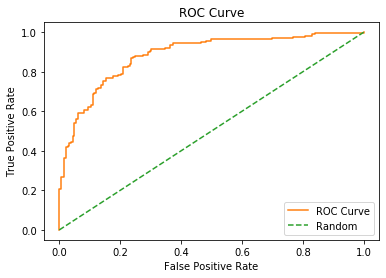

AUC SCORE 0.8839634941329856
Testing Time:  0.727 Sec


In [15]:

def predictProb(tweet):
    '''For a given tweet this predicts whether it belongs to class 0 or 4'''
    likelihood0 = 0.0
    likelihood4 = 0.0
    for word in str(tweet).lower().split():
        if word not in Vocab:
            likelihood0 += np.log(1/(Ni0 + len(Vocab)))
            likelihood4 += np.log(1/(Ni4 + len(Vocab)))
        else:
            likelihood0 += np.log(Theta0[word])
            likelihood4 += np.log(Theta4[word])
    likelihood0 += np.log(Phi0)
    likelihood4 += np.log(Phi4)
    
    return likelihood0, likelihood4


def plotROC_Curve(data):
    '''Plot ROC Curve'''
    sTime = time.time()
    arr = [data[:,0]]
    arr = arr[0].reshape(len(data), 1)
    binArr = []
    for i in range(len(arr)):
        if arr[i] == 4:
            binArr.append(1)
        else:
            binArr.append(0)
    binArr = np.array(binArr).reshape(len(data), 1)
    
    predicted = np.array([predictProb(eg) for eg in data[:,1]]).reshape(len(data),2)
    #print(predicted)
    prob4 = []
    for i in range(len(predicted)):
        prob4.append(abs(predicted[i][1])/abs(predicted[i][0] + predicted[i][1]))
        
    prob4 = np.array(prob4)
    lin = np.linspace(0, 1, 20)
    fig = plt.figure(1)    
    fpr, tpr, th = roc_curve(binArr, prob4, pos_label=None)
    plt.plot(tpr, fpr, c="tab:orange", label="ROC Curve")
    plt.plot(lin, lin, c="tab:green", linestyle="dashed", label="Random")
    plt.legend()
    plt.ylabel("True Positive Rate")
    plt.xlabel("False Positive Rate")
    plt.title("ROC Curve")
    plt.show()
    fig.savefig("plots/ROC_CURVE.png", dpi= 300, pad_inches=0.1, format='png')
    
    print("AUC SCORE", auc(tpr, fpr))
    
    eTime = time.time()    
    print("Testing Time: ", round(eTime - sTime, 3), "Sec")

Vocab, WordsFreq0, WordsFreq4, Ni0, Ni4, Phi0, Phi4, Theta0, Theta4 = trainNB(DTrain.to_numpy())
testAcc, testD = testNB(DTest.to_numpy())
print(testAcc)
plotROC_Curve(DTest.to_numpy())

Vocab, WordsFreq0, WordsFreq4, Ni0, Ni4, Phi0, Phi4, Theta0, Theta4 = trainNB(DTrain_P.to_numpy())
plotROC_Curve(DTrain_P.to_numpy())

In [127]:
DTrain_BG = pd.read_csv("Processed_Training_Data_withoutPunct.csv", usecols = [1,2], encoding = "ISO-8859-1")
DTrain_BG['Comments'].replace('', np.nan, inplace=True)
DTrain_BG.dropna(subset=['Comments'], inplace=True)
#DTrain_BG = DTrain.filter(['Class','Comments'], axis=1)

Vocab, WordsFreq0, WordsFreq4, Ni0, Ni4, Phi0, Phi4, Theta0, Theta4 = trainNB(DTrain_BG.to_numpy())
DTrain_BG["Comments"] = DTrain_BG['Comments'].apply(lambda x: generateNgrams(x.lower(),2))
Vocab, WordsFreq0, WordsFreq4, Ni0, Ni4, Phi0, Phi4, Theta0, Theta4 = trainBigramNB(DTrain_BG.to_numpy())
'''
Vocab.update(Vocab1)
WordsFreq0.update(WordsFreq01)
WordsFreq4.update(WordsFreq41)
Ni0 += Ni01
Ni4 += Ni41
Theta0.update(Theta01)
Theta4.update(Theta41)'''

DTest_BG = modelWithPreProcessing(DTest.filter(['Class','Comments'], axis=1))
DTest_BG['Comments'].replace('', np.nan, inplace=True)
DTest_BG.dropna(subset=['Comments'], inplace=True)
#DTest_BG = DTest.filter(['Class','Comments'], axis=1)
#DTest_BG["Comments"] = DTest_BG['Comments'].apply(lambda x: generateNgrams(x.lower(),2))
#DTest_BG
AccuTest, ResultsTest = testNGramModel(DTest_BG.to_numpy())
print("Test Accuracy = {}%".format(AccuTest))

#Vocab = {k: v for k, v in sorted(Vocab.items(), key=lambda item: item[1], reverse=True)}
#Vocab


@@@@@@@@---Naive Bayes Training in progress...!---@@@@@@@@

Calculating Parameters...!
Training Time:  7.74 Sec

@@@@@@@@---NGram - Naive Bayes Training in progress...!---@@@@@@@@

Calculating Parameters...!
Training Time:  18.929 Sec
----Cleaning in Progress----
Cleaning RunTime 0.060848236083984375

Testing in progress...!
Testing Time:  0.012 Sec
Test Accuracy = 82.173%


In [111]:
VSorted = {k: v for k, v in sorted(Vocab.items(), key=lambda item: item[1], reverse=True)}
WF0Sorted = {k: v for k, v in sorted(WordsFreq0.items(), key=lambda item: item[1], reverse=True)}
WF4Sorted = {k: v for k, v in sorted(WordsFreq4.items(), key=lambda item: item[1], reverse=True)}

Theta0Sorted = {k: v for k, v in sorted(Theta0.items(), key=lambda item: item[1], reverse=True)}
Theta4Sorted = {k: v for k, v in sorted(Theta4.items(), key=lambda item: item[1], reverse=True)}


In [75]:
DTrain_FE = pd.read_csv("Processed_Training_Data_withoutPunct.csv", usecols = [1,2], encoding = "ISO-8859-1")
    
DTrain_FE['Comments'].replace('', np.nan, inplace=True)
DTrain_FE.dropna(subset=['Comments'], inplace=True)

print("\n@@@@@@@@---Calculate Train Accuracy...!---@@@@@@@@")
#AccuTrain_FE, ResultsTrain_FE = testFEModel1(DTrain_FE.to_numpy())
print("\n@@@@@@@@---Calculate Test Accuracy...!---@@@@@@@@")
DTest_FE = readCSV("testdata.manual.2009.06.14.csv")
#DTest_FE = modelWithPreProcessing(DTest_FE)
#DTest_FE['Comments'].replace('', np.nan, inplace=True)
#DTest_FE.dropna(subset=['Comments'], inplace=True)
AccuTest_FE, ResultsTest_FE = testFEModel1(DTest_FE.to_numpy())

#print("\nTrain Accuracy = {}%".format(AccuTrain_FE))
print("Test Accuracy = {}%".format(AccuTest_FE))


@@@@@@@@---Calculate Train Accuracy...!---@@@@@@@@

@@@@@@@@---Calculate Test Accuracy...!---@@@@@@@@

 Testing in progress...!
Testing Time:  0.514 Sec
Test Accuracy = 83.00800000000001%


In [ ]:
DTrain_PP = pd.read_csv("Processed_Training_Data_withoutPunct.csv", usecols = [1,2], encoding = "ISO-8859-1")
#features_train, features_test, labels_train, labels_test = train_test_split(
#    DTrain_PP["Comments"], DTrain_PP["Class"], test_size=0.000001, random_state=10)

DTrain_PP['Comments'].replace('', np.nan, inplace=True)
DTrain_PP.dropna(subset=['Comments'], inplace=True)
DTest_PP = modelWithPreProcessing(DTest)
DTest_PP['Comments'].replace('', np.nan, inplace=True)
DTest_PP.dropna(subset=['Comments'], inplace=True)

vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5,
                             stop_words='english')

#TestFeatures = vectorizer.transform(DTest_PP['Comments'].to_numpy())
TrainFeatures = vectorizer.fit_transform(DTrain_PP['Comments'].to_numpy())

t0 = time.time()
model = GaussianNB()
model.fit(TrainFeatures.toarray()[0:100], np.array(DTrain_PP['Class']))
print(f"\nTraining time: {round(time()-t0, 3)}s")
t0 = time.time()
score_train = model.score(TrainFeatures, DTrain_PP['Class'].to_numpy())
print(f"Prediction time (train): {round(time()-t0, 3)}s")
t0 = time.time()
score_test = model.score(TestFeatures, DTest_PP['Class'].to_numpy())
print(f"Prediction time (test): {round(time()-t0, 3)}s")

In [ ]:
VSorted = {k: v for k, v in sorted(Vocab.items(), key=lambda item: item[1], reverse=True)}
WF0Sorted = {k: v for k, v in sorted(WordsFreq0.items(), key=lambda item: item[1], reverse=True)}
WF4Sordet = {k: v for k, v in sorted(WordsFreq4.items(), key=lambda item: item[1], reverse=True)}

Theta0Sorted = {k: v for k, v in sorted(Theta0.items(), key=lambda item: item[1], reverse=True)}
#Theta0Sorted
Theta4Sorted = {k: v for k, v in sorted(Theta4.items(), key=lambda item: item[1], reverse=True)}
Theta4Sorted

In [55]:
help(type(self))

NameError: name 'self' is not defined

In [ ]:
#len(Vocab),len(WordsFreq0),len(WordsFreq4), Ni0, Ni4, Vocab['a'], WordsFreq0['a'],WordsFreq4['a']

len(Theta0), len(Theta4), Phi0, Phi4, Theta4['modi'], Theta0['modi']

In [ ]:

    data[:,1] = np.array(list(map(lambda x: deleteUrls(x.lower()), data[:,1])))
    data[:,1] = np.array(list(map(lambda x: deleteMentionedUsers(x), data[:,1])))
    data[:,1] = np.array(list(map(lambda x: deleteDigits(x), data[:,1])))
    data[:,1] = np.array(list(map(lambda x: remove_stopwords(x), data[:,1])))
    data[:,1] = np.array(list(map(lambda x: deletePunctuations(x), data[:,1])))
    eTime = time.time()

In [ ]:
DTrain_P = DTrain.filter(['Class','Comments'], axis=1)

sTime = time.time()

DTrain_P['Comments'] = DTrain_P['Comments'].apply(lambda x: x.lower().split())
DTrain_P['Comments'].apply(lambda x: buildVocab(x))

eTime = time.time()
print("Run Time: ", eTime - sTime)
DTrain_P.head(10)

In [ ]:
d_sorted = sorted(d.items(), key=lambda x: x[1], reverse=True)

In [ ]:
DTrain_P = DTrain.filter(['Class','Comments'], axis=1)
sTime = time.time()

DTrain_P['Comments'] = DTrain_P['Comments'].apply(lambda x: deleteUrls(x.lower()))
DTrain_P['Comments'] = DTrain_P['Comments'].apply(lambda x: deleteMentionedUsers(x))
DTrain_P['Comments'] = DTrain_P['Comments'].apply(lambda x: deleteDigits(x))
DTrain_P['Comments'] = DTrain_P['Comments'].apply(lambda x: remove_stopwords(x))
DTrain_P['Comments'] = DTrain_P['Comments'].apply(lambda x: deletePunctuations(x))


eTime = time.time()
print("Run Time: ", eTime - sTime)
DTrain_P.head()

In [ ]:
DTrain_P = DTrain.filter(['Class','Comments'], axis=1)
sTime = time.time()

#DTrain_P['Comments'] = DTrain_P['Comments'].apply(lambda x: deleteUrls(x.lower()))
#DTrain_P['Comments'] = DTrain_P['Comments'].apply(lambda x: deleteMentionedUsers(x))
#DTrain_P['Comments'] = DTrain_P['Comments'].apply(lambda x: deletePunctuations(x))
#DTrain_P['Comments'] = DTrain_P['Comments'].apply(lambda x: deleteDigits(x))
DTrain_P['Comments'] = DTrain_P['Comments'].apply(lambda x: remove_stopwords(x))


eTime = time.time()
print("Run Time: ", eTime - sTime)
DTrain_P.head()

In [ ]:
DTrain_P = DTrain.filter(['Class','Comments'], axis=1)
sTime = time.time()

#DTrain_P['Comments'] = DTrain_P['Comments'].apply(lambda x: deleteUrls(x.lower()))
#DTrain_P['Comments'] = DTrain_P['Comments'].apply(lambda x: deleteMentionedUsers(x))
#DTrain_P['Comments'] = DTrain_P['Comments'].apply(lambda x: deletePunctuations(x))
#DTrain_P['Comments'] = DTrain_P['Comments'].apply(lambda x: deleteDigits(x))
DTrain_P['Comments'] = DTrain_P['Comments'].apply(lambda x: rem_stop(x))


eTime = time.time()
print("Run Time: ", eTime - sTime)
DTrain_P.head()

In [ ]:
DArr = np.array(DTrain['Comments'])
DArr.reshape(DArr.shape[0], 1)

sTime = time.time()
DTrain_P['Comments'] = DTrain_P['Comments'].apply(lambda x: deleteMentionedUsers(x.lower()))
DTrain_P['Comments'] = DTrain_P['Comments'].apply(lambda x: deletePunctuations(x))

eTime = time.time()
print("Run Time: ", eTime - sTime)
DTrain_P.head()